In [1]:
# https://developers.google.com/optimization/introduction/python

In [2]:
%reset -sf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Define problem

In [3]:
df = pd.read_pickle("../preprocessing/processed_dataframe.pkl")
# df

In [4]:
nodes = pd.DataFrame()
nodes["supplies"] = df["TOTAL"]
nodes["x"] = df["x_centre"]
nodes["y"] = df["y_centre"]

start_nodes = []
end_nodes   = []
unit_costs  = []
for i,row in df.iterrows():
    for adj, cst in zip(row["adjacent"], row["shared_param"]):
        start_nodes.append(i)
        end_nodes.append(adj)
        unit_costs.append(cst)

edges = pd.DataFrame()
edges["start_nodes"] = start_nodes
edges["end_nodes"]   = end_nodes
edges["unit_costs"]  = unit_costs
edges["capacities"]  = [9999999]*len(start_nodes) # disabled
edges["flows"]       = [0]*len(start_nodes)
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply('-'.join, axis=1)
edges.index = edges["names"]
N = len(nodes) # the number of nodes at init

In [5]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,names
names,,,,,,
x283-314,283,314,0.012559,9999999,0,x283-314
x131-22,131,22,0.004319,9999999,0,x131-22
x230-190,230,190,0.024645,9999999,0,x230-190
x89-131,89,131,0.005203,9999999,0,x89-131
x15-29,15,29,0.018718,9999999,0,x15-29


# Augment nodes to a common sink

In [6]:
def augment_nodes(nodes, edges):
    for i,ss in enumerate(nodes["supplies"]):
        edges.loc[len(edges)] = [i, len(nodes), 1, 9999999, 0,
                                 "x"+str(i)+"-"+str(len(nodes))]
        edges.loc[len(edges)] = [len(nodes), i, 1, 9999999, 0,
                                 "x"+str(i)+"-"+str(len(nodes))]
    nodes.loc[len(nodes)] = [-sum(nodes["supplies"]), 103.5, 1.2]
    edges.index = edges["names"]
    return nodes, edges

In [7]:
nodes, edges = augment_nodes(nodes, edges)
# nodes
# edges

# Making graph undirected

In [8]:
def make_undirected(edges):
    for i,row in edges.iterrows():
        row = row.copy()
        row["end_nodes"], row["start_nodes"] = row["start_nodes"], row["end_nodes"]
        row["names"] = "x"+str(row["start_nodes"])+"-"+str(row["end_nodes"])
        edges.loc[len(edges)] = row
    edges.index = edges["names"]
    return edges

In [9]:
%%time
edges = make_undirected(edges)
# edges

CPU times: user 6.94 s, sys: 143 ms, total: 7.08 s
Wall time: 7.13 s


# Generate adjacency matrix

In [10]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_capacities = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flows      = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_names      = [["x"+str(i)+"-"+str(j)
                          for i in range(N+1)] 
                         for j in range(N+1)]
    
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        
    for y,x,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names = get_adjacency_matrix(edges)

In [11]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

# Visualisation

In [12]:
matrix_capacities[30][0]

9999999

In [13]:
edges

,start_nodes,end_nodes,unit_costs,capacities,flows,names
names,,,,,,
x0-40,0,40,0.010374,9999999,0,x0-40
x0-76,0,76,0.004139,9999999,0,x0-76
x0-21,0,21,0.010858,9999999,0,x0-21
x0-28,0,28,0.009546,9999999,0,x0-28
x1-2,1,2,0.001659,9999999,0,x1-2
x1-35,1,35,0.007406,9999999,0,x1-35
x1-33,1,33,0.002066,9999999,0,x1-33
x1-38,1,38,0.004597,9999999,0,x1-38
x1-7,1,7,0.003097,9999999,0,x1-7


In [14]:
def plot_graph(nodes, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(nodes["supplies"]):
        labeldict[i] = s

    plt.figure(figsize=(14,10))
    
    pos=nx.circular_layout(G)
    pos={}
    for i,node in nodes.iterrows():
        pos[i] = [node["x"], node["y"]]
    
    for edge in G.edges(data=True):
        w = edge[2]['flow']
        if w > 0:
            size = np.log(1+w)
            nx.draw_networkx_edge_labels(G,pos, edgelist=[(edge[0],edge[1])], 
                                         edge_labels = {(edge[0],edge[1]): w})
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], 
                                   width=size, arrowsize=size*10)
            
    nx.draw_networkx_nodes(G, pos, with_labels=True, font_size=15, 
                           node_size=200, node_color="yellow")
    nx.draw_networkx_labels(G, pos, labels=labeldict)

    plt.show()

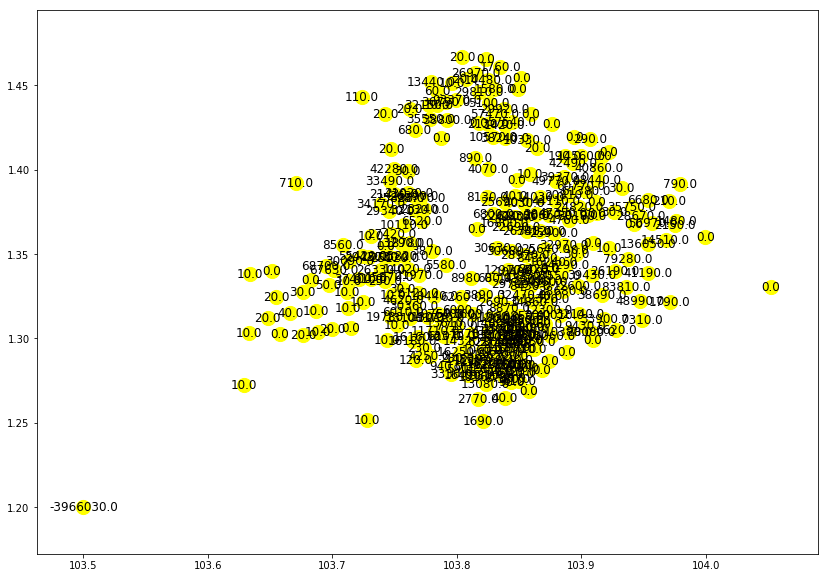

In [15]:
plt.show()
plot_graph(nodes, edges)

# Min-cost flow as a linear program

In [16]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.IntVar(0.0, matrix_capacities[i][j], 'x'+str(i)+"-"+str(j))
      for j in range(N+1)]
     for i in range(N+1)]

# define supplies
for i in range(N):
    solver.Add(sum([X[i][j] for j in range(N+1)])
             - sum([X[j][i] for j in range(N+1)])
            == nodes["supplies"][i])

In [17]:
# additional constraints
B1 = [solver.IntVar(0.0, 1.0, 'b'+str(i)+"-"+str(N))
      for i in range(N)]
B2 = [solver.IntVar(0.0, 1.0, 'b'+str(N)+"-"+str(i))
      for i in range(N)]

for i in range(N):
    solver.Add(X[i][N] <= 99999999*B1[i])
    solver.Add(X[N][i] <= 99999999*B2[i])

# num_nodes_init
for i in range(N):
    solver.Add(sum(B1) + sum(B2) <= 5)

In [18]:
dir(solver)

['ABNORMAL',
 'AT_LOWER_BOUND',
 'AT_UPPER_BOUND',
 'Add',
 'BASIC',
 'BOP_INTEGER_PROGRAMMING',
 'BoolVar',
 'CBC_MIXED_INTEGER_PROGRAMMING',
 'CLP_LINEAR_PROGRAMMING',
 'Clear',
 'ComputeConstraintActivities',
 'ComputeExactConditionNumber',
 'Constraint',
 'EnableOutput',
 'ExportModelAsLpFormat',
 'ExportModelAsMpsFormat',
 'ExportModelToProto',
 'FEASIBLE',
 'FIXED_VALUE',
 'FREE',
 'FillSolutionResponseProto',
 'GLOP_LINEAR_PROGRAMMING',
 'INFEASIBLE',
 'Infinity',
 'IntVar',
 'InterruptSolve',
 'Iterations',
 'LoadModelFromProto',
 'LoadSolutionFromProto',
 'LookupConstraint',
 'LookupVariable',
 'Maximize',
 'Minimize',
 'NOT_SOLVED',
 'NextSolution',
 'NumConstraints',
 'NumVar',
 'NumVariables',
 'OPTIMAL',
 'Objective',
 'RowConstraint',
 'SetHint',
 'SetNumThreads',
 'SetSolverSpecificParametersAsString',
 'SetTimeLimit',
 'Solve',
 'SolveWithProto',
 'Sum',
 'SupportsProblemType',
 'SuppressOutput',
 'UNBOUNDED',
 'Var',
 'VerifySolution',
 'WallTime',
 '__class__',
 '__de

In [19]:
# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j]
                          for j in range(N+1)])
                     for i in range(N+1)]))

solver.set_time_limit(1000)

# sum[matrix_unit_costs[i][j] * X[i][j] for j in range(num_nodes)]
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 102397
Number of constraints = 1272


In [20]:
# print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

In [21]:
status = solver.Solve()

# Visualise output

In [22]:
if status != pywraplp.Solver.FEASIBLE:
    print('The problem does not have an optimal solution.')
    
print('Solution:')
print('Objective value =', solver.Objective().Value())
print('')
print('Advanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 4042358.7948767585

Advanced usage:
Problem solved in 4524.000000 milliseconds
Problem solved in 587 iterations
Problem solved in 10 branch-and-bound nodes


In [23]:
matrix_flows = [[x.solution_value() for x in xxx] for xxx in X]
for i,row in enumerate(matrix_flows):
    for j,cell in enumerate(row):
        if matrix_flows[i][j] > 0:
            edges.at["x"+str(i)+"-"+str(j),"flows"] = matrix_flows[i][j]

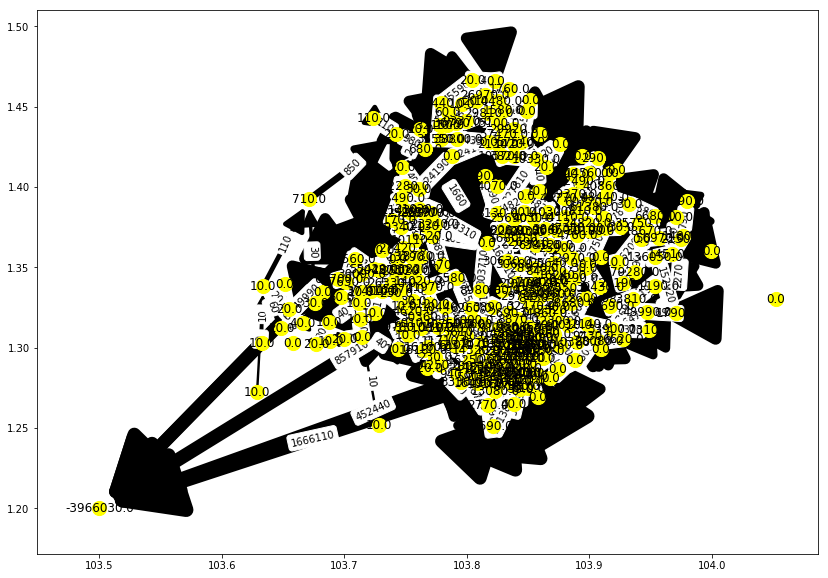

In [24]:
plot_graph(nodes, edges)

In [25]:
# edges